# The effect of adjusting for precision variables
For CRENAI 2018-09-14
REFERENCE kaz_yos: https://rpubs.com/kaz_yos/non-collapsibility2

## Linear regression (identity-link)

$e$ = exposure (randomized)    
$p_1$ = predictor variable 1 (Not confounding == not associated with $e$)    
$p_2$ = predictor variable 2    
$$Y = \beta_0 + \beta_1 e + \beta_2 p_1 + \beta_3 p_2 + \epsilon$$


Because "$e$" is randomized, the margianl model 

$E[Y|e] = \beta_0 + \beta_1 e$

should give an unbiased estimator. Let's check that. 

$E[Y|e] = \beta_0 + \beta_1 e + \beta_2 E[p_1 | e] + \beta_2 E[p_2 | e]$

And because "$p_1$" and "$p_2$" are not associated with "$e$", they are constant when conditioned on $e$.    
thus,    

$E(Y|e) = \beta_0^* + \beta_1 e$

The $\beta_1$ from the marginal model is indeed giving an unbiased estimate of $\beta_1$.     
**However**, the following conditional model will give a better prediciton == smaller SE, more Power.    

$E[Y | e, p_1, p_2] = \beta_0 + \beta_1 e + \beta_2 p_1 + \beta_3 p_2$



## Poisson regression (log-link)

$log(Y) = \beta_0 + \beta_1 e + \beta_2 p_1 + \beta_3 p_2 + \epsilon$


* Conditining only on "$e$"   

$log(E[Y|e]) = \beta_0 + \beta_1 e + \beta_2 E[p_1|e] + \beta_3 E[p_2|e]$    
Similarly,    
$log(E[Y|e]) = \beta_0^* + \beta_1 e$

And this is essentially the same as the marginal model. Again, marginal model reports the unbiased estimator of $\beta_1$. But the same as the above, the following conditional model has better prediction.
$ log(E[Y|e,p_1, p_2]) = \beta_0 + \beta_1 e + \beta_2 p_1 + \beta_3 p_2 $

## Logistic regression (logistic-link)
$log(OR) = \beta_0 + \beta_1 e + \beta_2 p_1 + \beta_3 p_2 + \epsilon$, thus,
$$ Y = \frac{e^{(\beta_0 + \beta_1 e + \beta_2 p_1 + \beta_3 p_2 + \epsilon)}}{1 + e^{(\beta_0 + \beta_1 e + \beta_2 p_1 + \beta_3 p_2 + \epsilon)}}$$


* Only conditioned on "$e$"
$$E[Y|e] = \frac{exp{(\beta_0 + \beta_1 e + C)}}{1 + exp{(\beta_0 + \beta_1 e + C)}}$$

where,
$$(C =  E[p_1 | e] + \beta_2 E[p_2 | e])$$

So, 
$$E[Y|e] = \frac{exp{(\beta_0 + \beta_1 e)}}{exp(-C) + exp{(\beta_0 + \beta_1 e)}}$$

When comparing this to the marginal model, 

$$E[Y|e] = \frac{exp{(\beta_0 + \beta_1 e)}}{1 + exp{(\beta_0 + \beta_1 e)}}$$

Two models are not in the convenient relationship as in the prior two models. $\beta_1$ estimates from the fully conditioned model and the marginal model are different. The marginal model is thought to be a valid model and giving unbiased estimator because "$e$" is randomized.. So where is the truth????


*Following is a simulation. The codes are mosoty written by kaz_yos (ref: https://rpubs.com/kazyos/non-collapsibility2)*

In [3]:
library(magrittr)
library(dplyr)
library(reshape2)
library(ggplot2)

In [4]:
Simulate <- function() {
  N=1000
  ## Outcome predictor 1
  p1 <- rnorm(n = N, mean = 0.3, sd = 0.6)
  ## Outcome predictor 2 associated with predictor 1
  p2 <- rnorm(n = N, mean = -0.4, sd = 0.8) + (p1/7)*runif(n = N)
  ## Randomly assign exposure
  e <- rbinom(n = N, size = 1, prob = 0.5)
  ## Set true model parameters
  beta0 <-  1
  beta1 <- -0.2
  beta2 <-  1.0
  beta3 <-  1.5
  
  ## Continuous outcome under the true model
  Ycont <- beta0 + beta1*e + beta2*p1 + beta3*p2 + rnorm(n = N, mean = 0, sd = 2)
  ## Poisson outcome under the true model
  EXPs = exp(beta0 + beta1*e + beta2*p1 + beta3*p2 + rnorm(n = N, mean = 0, sd = 0.4))
  Ycount=rpois(N, EXPs)
  ## Binomial outcome under the true model
  Ps = EXPs/(1+EXPs)
  Ydich = rbinom(N,1,Ps)

  
  ## Identity link: Conditional effect of exposure
  identity_conditional_coef_e <-
    glm(Ycont ~ e + p1 + p2, family = gaussian(link = "identity")) %>%
    summary %>% coefficients %>% .[2,c(1,4)]
  ## Identity link: Marginal effect of exposure (valid estimate as the exposure is randomized)
  identity_marginal_coef_e <-
    glm(Ycont ~ e, family = gaussian(link = "identity")) %>%
    summary %>% coefficients %>% .[2,c(1,4)]
  
  ## Logit link: Conditional effect of exposure
  logit_conditional_coef_e <-
    glm(Ydich ~ e + p1 + p2, family = binomial(link = "logit")) %>%
    summary %>% coefficients %>% .[2,c(1,4)]
  ## Logit link: Marginal effect of exposure (valid estimate as the exposure is randomized)
  logit_marginal_coef_e <-
    glm(Ydich ~ e, family = binomial(link = "logit")) %>%
    summary %>% coefficients %>% .[2,c(1,4)]
  
  ## Log link: Conditional effect of exposure
  log_conditional_coef_e <- 
    glm(Ycount ~ e + p1 + p2, family = poisson(link = "log")) %>% 
    summary %>% coefficients %>% .[2,c(1,4)]
  ## Log link: Marginal effect of exposure (valid estimate as the exposure is randomized)
  log_marginal_coef_e <- 
    glm(Ycount ~ e, family = poisson(link = "log")) %>% 
    summary %>% coefficients %>% .[2,c(1,4)]
  
  ##
  c(identity_marginal    = identity_marginal_coef_e[1],
    identity_conditional = identity_conditional_coef_e[1],
    logit_marginal       = logit_marginal_coef_e[1],
    logit_conditional    = logit_conditional_coef_e[1],
    log_marginal         = log_marginal_coef_e[1],
    log_conditional      = log_conditional_coef_e[1],
    identity_marginal    = identity_marginal_coef_e[2],
    identity_conditional = identity_conditional_coef_e[2],
    logit_marginal       = logit_marginal_coef_e[2],
    logit_conditional    = logit_conditional_coef_e[2],
    log_marginal         = log_marginal_coef_e[2],
    log_conditional      = log_conditional_coef_e[2])
}

set.seed(20150117)
resSims <- sapply(1:1000, function(x){Simulate()}) %>%
  t %>% data.frame %>% 
  melt(data          = .,
       id.vars       = NULL,
       variable.name = "variable",
       value.name    = "value")

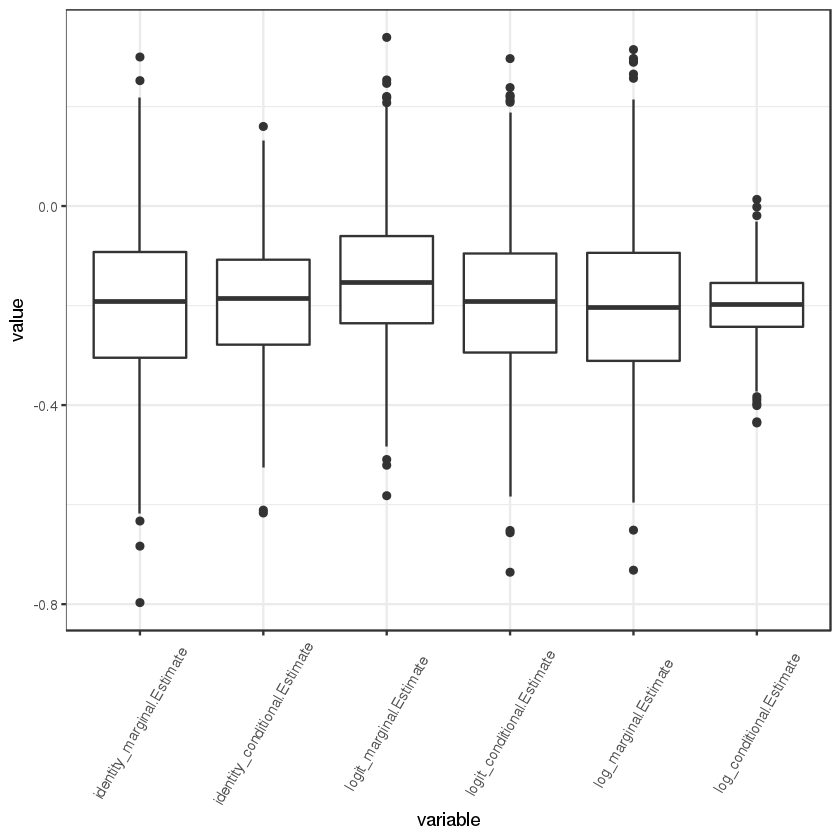

In [7]:
## ggplot for beta
ggplot(data = resSims[1:6000,], mapping = aes(x = variable, y = value)) +
  geom_boxplot() + 
  theme_bw() + theme(legend.key = element_blank(),
                     axis.text.x = element_text(angle = 60, vjust = 0.5))

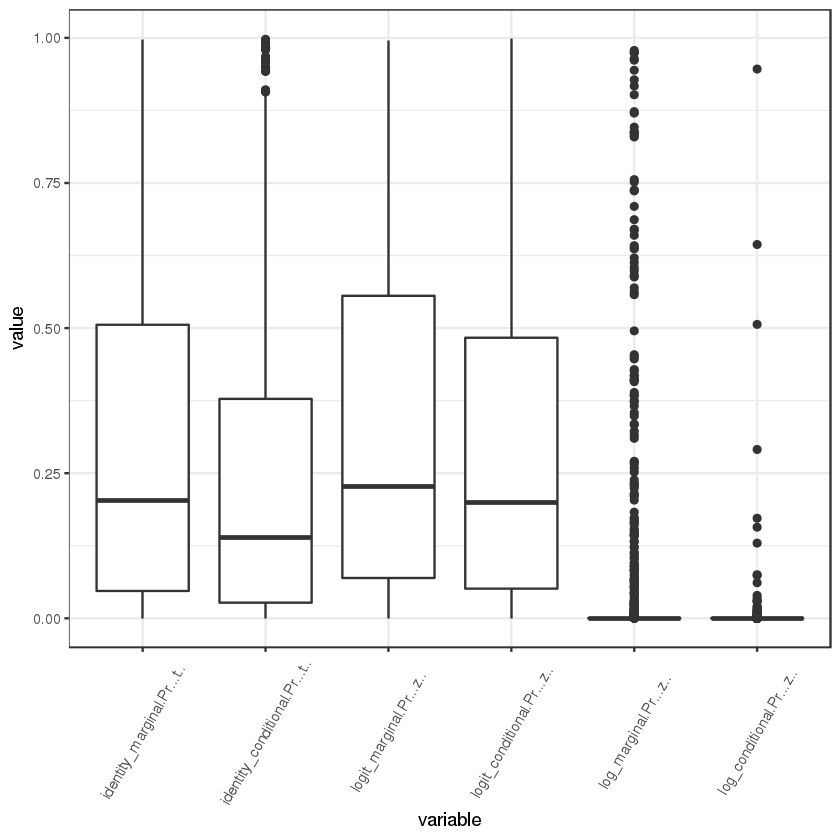

In [8]:
## ggplot for p-value
ggplot(data = resSims[6001:12000,], mapping = aes(x = variable, y = value)) +
  geom_boxplot() + 
  theme_bw() + theme(legend.key = element_blank(),
                     axis.text.x = element_text(angle = 60, vjust = 0.5))

In [14]:
## POWER: Rejected test among 1000 simulations (alpha = 0.05)
resSims[6001:12000,] %>% mutate(RJCT = value<0.05) %>% 
  group_by(variable) %>% 
  summarize_at(vars(RJCT), sum)

variable,RJCT
identity_marginal.Pr...t..,253
identity_conditional.Pr...t..,329
logit_marginal.Pr...z..,203
logit_conditional.Pr...z..,248
log_marginal.Pr...z..,877
log_conditional.Pr...z..,990
